In [1]:
# ==============================
# 데이터 로딩 (addition.txt)
# ==============================
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ==============================
# 시드 고정
# ==============================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# ------------------------------
# Dataset 정의 (고정 길이, '_' 시작)
# ------------------------------
class AddDataset(Dataset):
    def __init__(self, samples, stoi=None, itos=None):
        self.samples = samples

        if stoi is None:
            # 전체 문자 + '_' 포함
            vocab = set("".join(s for s, _ in samples) +
                        "".join(t for _, t in samples) + "_")
            self.stoi = {s: i for i, s in enumerate(sorted(vocab))}
        else:
            self.stoi = stoi

        self.itos = {i: s for s, i in self.stoi.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        src, tgt = self.samples[idx]

        # 입력: 그대로 (길이 7 보장, 뒤 공백 포함)
        src_ids = [self.stoi[c] for c in src]

        # 출력: '_' + tgt (길이 5 보장, tgt도 뒤 공백 포함)
        tgt_ids = [self.stoi["_"]] + [self.stoi[c] for c in tgt]

        return torch.tensor(src_ids), torch.tensor(tgt_ids), src, tgt


# ------------------------------
# collate_fn: pad 불필요, 그냥 stack
# ------------------------------
def collate_fn(batch):
    src_batch, tgt_batch, src_strs, tgt_strs = zip(*batch)
    return torch.stack(src_batch), torch.stack(tgt_batch), src_strs, tgt_strs


# ==============================
# 데이터셋 불러오기
# ==============================
all_samples = []
with open("addition.txt", encoding="utf-8") as f:
    for line in f:
        line = line[:-1] if line.endswith("\n") else line  # 개행만 제거
        if not line:
            continue
        src, tgt = line.split("_")  # '_' 기준 분리

        # 항상 src=7, tgt=4 고정
        assert len(src) == 7, f"src 길이 오류: {repr(src)}"
        assert len(tgt) == 4, f"tgt 길이 오류: {repr(tgt)}"

        all_samples.append((src, tgt))

# train/val 분리
train_samples, test_samples = train_test_split(all_samples, test_size=0.1, random_state=42)

# Dataset 생성
train_dataset = AddDataset(train_samples)
test_dataset = AddDataset(test_samples, stoi=train_dataset.stoi, itos=train_dataset.itos)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)


# ==============================
# 데이터 예시 출력
# ==============================
for src_batch, tgt_batch, src_strs, tgt_strs in train_loader:
    print("입력 배치 shape:", src_batch.shape)  # [B, 7]
    print("출력 배치 shape:", tgt_batch.shape)  # [B, 5]

    for i in range(len(src_strs)):
        print(f"\n[샘플 {i}]")
        print(f"  원문: {repr(src_strs[i])} → {repr(tgt_strs[i])}")

        # 토큰 변환 확인
        src_tokens = [train_dataset.itos[idx.item()] for idx in src_batch[i]]
        tgt_tokens = [train_dataset.itos[idx.item()] for idx in tgt_batch[i]]

        print("  입력 인덱스:", src_batch[i].tolist())
        print("  입력 토큰 :", src_tokens)
        print("  출력 인덱스:", tgt_batch[i].tolist())
        print("  출력 토큰 :", tgt_tokens)
        break

    break  # 첫 배치만 확인


Device: cuda:7
입력 배치 shape: torch.Size([128, 7])
출력 배치 shape: torch.Size([128, 5])

[샘플 0]
  원문: '72+147 ' → '219 '
  입력 인덱스: [9, 4, 1, 3, 6, 9, 0]
  입력 토큰 : ['7', '2', '+', '1', '4', '7', ' ']
  출력 인덱스: [12, 4, 3, 11, 0]
  출력 토큰 : ['_', '2', '1', '9', ' ']


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ----------------------------------------------------------
# Encoder
# ----------------------------------------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, num_layers,
            batch_first=True
        )

    def forward(self, src):
        """
        src: [B, 7]
        """
        embedded = self.embedding(src)                        # [B, 7, E]
        encoder_outputs, (hidden, cell) = self.lstm(embedded) # [B, 7, H]
        return encoder_outputs, hidden, cell


# ----------------------------------------------------------
# Luong Attention (dot-product)
# ----------------------------------------------------------
class LuongAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, decoder_state, encoder_outputs):
        """
        decoder_state: [B, H]
        encoder_outputs: [B, S, H]
        """
        # dot product attention
        scores = torch.bmm(encoder_outputs, decoder_state.unsqueeze(2)).squeeze(2)  # [B, S]
        scores = scores / (encoder_outputs.size(-1) ** 0.5)

        attn_weights = F.softmax(scores, dim=-1)               # [B, S]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # [B, H]
        return attn_weights, context


# ----------------------------------------------------------
# Decoder with Attention
# ----------------------------------------------------------
class LuongDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(
            emb_dim, hidden_dim, num_layers,
            batch_first=True
        )
        self.attn = LuongAttention()

        self.fc_out = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, input_token, hidden, cell, encoder_outputs):
        """
        input_token: [B]  (직전 출력 문자 인덱스)
        """
        emb = self.embedding(input_token).unsqueeze(1)       # [B, 1, E]
        out, (hidden, cell) = self.lstm(emb, (hidden, cell)) # out: [B, 1, H]
        dec_state = out.squeeze(1)                           # [B, H]

        # Attention
        attn_weights, context = self.attn(dec_state, encoder_outputs)

        combined = torch.cat([dec_state, context], dim=-1)   # [B, 2H]
        prediction = self.fc_out(combined)                   # [B, vocab]

        return prediction, hidden, cell, attn_weights


# ----------------------------------------------------------
# Seq2Seq with Luong Attention
# ----------------------------------------------------------
class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, tf_ratio=0.5):
        """
        src: [B, 7]
        trg: [B, 5]  (출력: '_' + 4자리 결과)
        """
        batch_size = src.size(0)
        trg_len = trg.size(1)     # 5
        trg_vocab_size = self.decoder.fc_out[-1].out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size, device=self.device)

        # 인코더 실행
        encoder_outputs, hidden, cell = self.encoder(src)

        # 첫 입력은 항상 "_" (즉, trg[:,0])
        input_token = trg[:, 0]

        for t in range(1, trg_len):
            pred, hidden, cell, _ = self.decoder(
                input_token, hidden, cell, encoder_outputs
            )
            outputs[:, t, :] = pred

            teacher_force = torch.rand(1).item() < tf_ratio
            top1 = pred.argmax(1)

            input_token = trg[:, t] if teacher_force else top1

        return outputs


In [3]:
import torch

@torch.no_grad()
def greedy_decode_seq2seq(model, src, stoi, itos, device, max_len=4):
    """
    src: [1, 7] 입력 텐서
    max_len: 출력 고정 길이 (
    """
    model.eval()
    encoder_outputs, hidden, cell = model.encoder(src)

    # 첫 입력은 항상 '_' (출력 맨 앞 기호)
    input_token = torch.tensor([stoi["_"]], device=device)
    outputs = []  
    
    for _ in range(1, max_len):  # 나머지 4글자 예측
        pred, hidden, cell, _ = model.decoder(
            input_token, hidden, cell, encoder_outputs
        )
        top1 = pred.argmax(1)  # [1]
        outputs.append(top1.item())
        input_token = top1

    return outputs


@torch.no_grad()
def evaluate_seq2seq(model, x, stoi, itos, device, max_len=4):
    """
    x: 입력 문자열 (예: "123+456")
    """
    # 1. 문자열 → 인덱스
    x_idx = [stoi[c] for c in x]   # 공백 포함
    src = torch.tensor(x_idx, device=device).unsqueeze(0)  # [1, 7]

    # 2. Greedy 디코딩
    pred_idx = greedy_decode_seq2seq(model, src, stoi, itos, device, max_len)

    # 3. 인덱스 → 문자열
    pred = "".join([itos[i] for i in pred_idx])
    return pred


In [4]:
# ==============================
# 하이퍼파라미터 & 모델 초기화 (Seq2Seq + Attention)
# ==============================
import torch
import torch.nn as nn
import torch.optim as optim

INPUT_DIM = len(train_dataset.stoi)
OUTPUT_DIM = len(train_dataset.stoi)
EMB_DIM = 32
HIDDEN_DIM = 192
N_EPOCHS = 50
PATIENCE = 15
MIN_DELTA = 1e-3
CLIP = 5.0
LR = 0.001

# Teacher Forcing Ratio 스케줄링
TF_START = 1.0
TF_END   = 0.3
TF_DECAY = (TF_START - TF_END) / N_EPOCHS  # epoch마다 감소량

# ------------------
# pad_idx는 필요 없음 (공백 " " 자체가 패딩 역할)
# ------------------

enc = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM).to(device)
dec = LuongDecoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM).to(device)
model = Seq2SeqAttn(enc, dec, device).to(device)

criterion = nn.CrossEntropyLoss()  # ignore_index 제거
optimizer = optim.Adam(model.parameters(), lr=LR)


In [5]:
# ==============================
# 평가 지표 (고정 길이, 공백 패딩 버전)
# ==============================
def token_accuracy_fn(y_pred, y_true):
    """
    토큰 단위 정확도
    y_pred: [B, T, V] (logits)
    y_true: [B, T] (ids)
    """
    pred_tokens = y_pred.argmax(dim=2)  # [B, T]
    correct = (pred_tokens == y_true)
    acc = correct.sum().float() / y_true.numel()
    return acc.item()


# ------------------------------
# 문자열 정리 함수 (공백 패딩만 제거)
# ------------------------------
def clean_str(s):
    return s.strip()


@torch.no_grad()
def exact_match_fn(model, dataset, stoi, itos, device, n_samples=None):
    """
    Exact Match 평가 (문장 단위 일치 여부 확인)
    """
    if n_samples is None or n_samples >= len(dataset):
        indices = range(len(dataset))
    else:
        indices = random.sample(range(len(dataset)), n_samples)

    correct = 0
    for idx in indices:
        _, _, src_str, tgt_str = dataset[idx]
        pred_str = evaluate_seq2seq(
            model, src_str,
            stoi=stoi, itos=itos,
            device=device,
            max_len=len(tgt_str)
        )

        # 공백 패딩 제거 후 비교
        if clean_str(pred_str) == clean_str(tgt_str):
            correct += 1

    return correct / len(indices)


In [6]:
# ----------------------------------------------------------
# 1 epoch 학습 (토큰 정확도까지 계산)
# ----------------------------------------------------------
def train_one_epoch(model, loader, optimizer, criterion, epoch, clip=5.0):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    tf_ratio = max(TF_END, TF_START - TF_DECAY * epoch)

    for src, trg, _, _ in tqdm(loader, desc=f"Train Epoch {epoch}", leave=False):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()

        # forward (teacher forcing 적용)
        output = model(src, trg, tf_ratio=1.0)  # 고정으로 사용 [B, T, V]

        # 손실 계산 (전체 시퀀스 기준)
        V = output.shape[-1]
        output_flat = output.contiguous().view(-1, V)   # [B*T, V]
        trg_flat = trg.contiguous().view(-1)            # [B*T]

        loss = criterion(output_flat, trg_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        # 토큰 정확도 계산
        B, T = trg.size()
        output_eval = output.view(B, T, V)
        trg_eval = trg
        acc = token_accuracy_fn(output_eval, trg_eval)

        total_loss += loss.item()
        total_acc += acc

    n = len(loader)
    return total_loss / n, total_acc / n


# ----------------------------------------------------------
# 1 epoch 평가 (토큰 정확도까지 계산)
# ----------------------------------------------------------
@torch.no_grad()
def evaluate_one_epoch(model, loader, criterion, epoch=0):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    for src, trg, _, _ in loader:
        src, trg = src.to(device), trg.to(device)
        output = model(src, trg, tf_ratio=0.0)  # [B, T, V]

        V = output.shape[-1]
        output_flat = output.contiguous().view(-1, V)   # [B*T, V]
        trg_flat = trg.contiguous().view(-1)            # [B*T]

        loss = criterion(output_flat, trg_flat)

        B, T = trg.size()
        output_eval = output.view(B, T, V)
        trg_eval = trg
        acc = token_accuracy_fn(output_eval, trg_eval)

        total_loss += loss.item()
        total_acc += acc

    n = len(loader)
    return total_loss / n, total_acc / n


In [7]:
# ==============================
# 학습 루프 (Exact Match 기반 Early Stopping)
# ==============================
train_losses, val_losses = [], []
train_accs, val_accs = [], []
val_exact_accs = []

best_val_eacc = 0.0
patience_counter = 0

for epoch in range(1, N_EPOCHS + 1):
    # ------------------------------
    # 1) 학습 / 평가
    # ------------------------------
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch, clip=CLIP)
    va_loss, va_acc = evaluate_one_epoch(model, test_loader, criterion)

    # Validation은 전체 데이터셋으로 Exact Match 평가
    va_eacc = exact_match_fn(
        model, test_dataset,
        stoi=train_dataset.stoi,
        itos=train_dataset.itos,
        device=device,
        n_samples=None
    )

    # ------------------------------
    # 2) 기록
    # ------------------------------
    train_losses.append(tr_loss); val_losses.append(va_loss)
    train_accs.append(tr_acc); val_accs.append(va_acc)
    val_exact_accs.append(va_eacc)

    print(f"Epoch {epoch:03d} | "
          f"Train Loss: {tr_loss:.5f} | Token Acc: {tr_acc:.5f} || "
          f"Val Loss: {va_loss:.5f} | Token Acc: {va_acc:.5f} | Exact Acc: {va_eacc:.5f} "
          f"(Best Val Exact: {best_val_eacc:.5f}, Patience: {patience_counter})")

    # ------------------------------
    # 3) 샘플 디버그 출력
    # ------------------------------
    if epoch % 1 == 0:
        src_ids, tgt_ids, src_str, tgt_str = random.choice(test_dataset)
        pred_raw = evaluate_seq2seq(
            model, src_str,
            stoi=train_dataset.stoi,
            itos=train_dataset.itos,
            device=device,
            max_len=len(tgt_str)   # 정답 길이와 동일하게 디코딩
        )
        print(f"[DEBUG] 입력: {src_str} | 정답: {tgt_str} | 예측: {pred_raw}")

    # ------------------------------
    # 4) Early Stopping (Exact Match 기준)
    # ------------------------------
    if va_eacc > best_val_eacc:   # discrete metric이므로 delta 불필요
        best_val_eacc = va_eacc
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered!")
            break


Epoch 001 | Train Loss: 1.84409 | Token Acc: 0.30464 || Val Loss: 1.69105 | Token Acc: 0.37453 | Exact Acc: 0.00860 (Best Val Exact: 0.00000, Patience: 0)
[DEBUG] 입력: 541+286 | 정답: 827  | 예측: 955


Epoch 002 | Train Loss: 1.45739 | Token Acc: 0.43473 || Val Loss: 1.63896 | Token Acc: 0.42777 | Exact Acc: 0.01940 (Best Val Exact: 0.00860, Patience: 0)
[DEBUG] 입력: 639+49  | 정답: 688  | 예측: 666


Epoch 003 | Train Loss: 1.29859 | Token Acc: 0.49099 || Val Loss: 1.52654 | Token Acc: 0.48133 | Exact Acc: 0.04300 (Best Val Exact: 0.01940, Patience: 0)
[DEBUG] 입력: 905+302 | 정답: 1207 | 예측: 122


Epoch 004 | Train Loss: 1.20687 | Token Acc: 0.52716 || Val Loss: 1.54932 | Token Acc: 0.51977 | Exact Acc: 0.06660 (Best Val Exact: 0.04300, Patience: 0)
[DEBUG] 입력: 278+29  | 정답: 307  | 예측: 310


Epoch 005 | Train Loss: 1.14328 | Token Acc: 0.55082 || Val Loss: 1.45806 | Token Acc: 0.54691 | Exact Acc: 0.10300 (Best Val Exact: 0.06660, Patience: 0)
[DEBUG] 입력: 5+337   | 정답: 342  | 예측: 340


Epoch 006 | Train Loss: 1.09494 | Token Acc: 0.56784 || Val Loss: 1.50041 | Token Acc: 0.55602 | Exact Acc: 0.13000 (Best Val Exact: 0.10300, Patience: 0)
[DEBUG] 입력: 0+94    | 정답: 94   | 예측: 94 


Epoch 007 | Train Loss: 1.05602 | Token Acc: 0.58071 || Val Loss: 1.47274 | Token Acc: 0.56398 | Exact Acc: 0.13100 (Best Val Exact: 0.13000, Patience: 0)
[DEBUG] 입력: 883+18  | 정답: 901  | 예측: 902


Epoch 008 | Train Loss: 1.02570 | Token Acc: 0.59128 || Val Loss: 1.53363 | Token Acc: 0.56750 | Exact Acc: 0.14500 (Best Val Exact: 0.13100, Patience: 0)
[DEBUG] 입력: 89+586  | 정답: 675  | 예측: 673


Epoch 009 | Train Loss: 1.00363 | Token Acc: 0.59839 || Val Loss: 1.51191 | Token Acc: 0.58160 | Exact Acc: 0.17600 (Best Val Exact: 0.14500, Patience: 0)
[DEBUG] 입력: 78+572  | 정답: 650  | 예측: 649


Epoch 010 | Train Loss: 0.97749 | Token Acc: 0.60891 || Val Loss: 1.70011 | Token Acc: 0.56582 | Exact Acc: 0.14020 (Best Val Exact: 0.17600, Patience: 0)
[DEBUG] 입력: 752+405 | 정답: 1157 | 예측: 114


Epoch 011 | Train Loss: 0.96373 | Token Acc: 0.61277 || Val Loss: 1.53918 | Token Acc: 0.59582 | Exact Acc: 0.22400 (Best Val Exact: 0.17600, Patience: 1)
[DEBUG] 입력: 389+49  | 정답: 438  | 예측: 440


Epoch 012 | Train Loss: 0.94985 | Token Acc: 0.61842 || Val Loss: 1.58655 | Token Acc: 0.60629 | Exact Acc: 0.24200 (Best Val Exact: 0.22400, Patience: 0)
[DEBUG] 입력: 648+60  | 정답: 708  | 예측: 706


Epoch 013 | Train Loss: 0.91830 | Token Acc: 0.63035 || Val Loss: 1.41803 | Token Acc: 0.62414 | Exact Acc: 0.28340 (Best Val Exact: 0.24200, Patience: 0)
[DEBUG] 입력: 10+19   | 정답: 29   | 예측: 27 


Epoch 014 | Train Loss: 0.91180 | Token Acc: 0.63237 || Val Loss: 1.40311 | Token Acc: 0.62430 | Exact Acc: 0.28040 (Best Val Exact: 0.28340, Patience: 0)
[DEBUG] 입력: 625+965 | 정답: 1590 | 예측: 159


Epoch 015 | Train Loss: 0.89785 | Token Acc: 0.63902 || Val Loss: 1.68946 | Token Acc: 0.59961 | Exact Acc: 0.18700 (Best Val Exact: 0.28340, Patience: 1)
[DEBUG] 입력: 0+288   | 정답: 288  | 예측: 289


Epoch 016 | Train Loss: 0.87135 | Token Acc: 0.64930 || Val Loss: 1.51352 | Token Acc: 0.62406 | Exact Acc: 0.28800 (Best Val Exact: 0.28340, Patience: 2)
[DEBUG] 입력: 401+352 | 정답: 753  | 예측: 748


Epoch 017 | Train Loss: 0.83904 | Token Acc: 0.66334 || Val Loss: 1.54972 | Token Acc: 0.64512 | Exact Acc: 0.34680 (Best Val Exact: 0.28800, Patience: 0)
[DEBUG] 입력: 483+77  | 정답: 560  | 예측: 560


Epoch 018 | Train Loss: 0.78627 | Token Acc: 0.68831 || Val Loss: 1.32331 | Token Acc: 0.68660 | Exact Acc: 0.50940 (Best Val Exact: 0.34680, Patience: 0)
[DEBUG] 입력: 343+94  | 정답: 437  | 예측: 437


Epoch 019 | Train Loss: 0.72476 | Token Acc: 0.71852 || Val Loss: 1.41095 | Token Acc: 0.69746 | Exact Acc: 0.54140 (Best Val Exact: 0.50940, Patience: 0)
[DEBUG] 입력: 861+414 | 정답: 1275 | 예측: 127


Epoch 020 | Train Loss: 0.67460 | Token Acc: 0.74015 || Val Loss: 1.13858 | Token Acc: 0.73375 | Exact Acc: 0.65000 (Best Val Exact: 0.54140, Patience: 0)
[DEBUG] 입력: 51+193  | 정답: 244  | 예측: 244


Epoch 021 | Train Loss: 0.62713 | Token Acc: 0.76074 || Val Loss: 1.01308 | Token Acc: 0.75699 | Exact Acc: 0.73040 (Best Val Exact: 0.65000, Patience: 0)
[DEBUG] 입력: 396+32  | 정답: 428  | 예측: 428


Epoch 022 | Train Loss: 0.59596 | Token Acc: 0.77305 || Val Loss: 0.92489 | Token Acc: 0.76504 | Exact Acc: 0.74700 (Best Val Exact: 0.73040, Patience: 0)
[DEBUG] 입력: 82+717  | 정답: 799  | 예측: 799


Epoch 023 | Train Loss: 0.56828 | Token Acc: 0.78352 || Val Loss: 0.89209 | Token Acc: 0.77230 | Exact Acc: 0.76600 (Best Val Exact: 0.74700, Patience: 0)
[DEBUG] 입력: 547+90  | 정답: 637  | 예측: 637


Epoch 024 | Train Loss: 0.55244 | Token Acc: 0.78849 || Val Loss: 0.75670 | Token Acc: 0.77918 | Exact Acc: 0.78120 (Best Val Exact: 0.76600, Patience: 0)
[DEBUG] 입력: 17+948  | 정답: 965  | 예측: 965


Epoch 025 | Train Loss: 0.54555 | Token Acc: 0.79062 || Val Loss: 0.75009 | Token Acc: 0.77672 | Exact Acc: 0.77260 (Best Val Exact: 0.78120, Patience: 0)
[DEBUG] 입력: 2+693   | 정답: 695  | 예측: 695


Epoch 026 | Train Loss: 0.54091 | Token Acc: 0.79147 || Val Loss: 0.75808 | Token Acc: 0.77906 | Exact Acc: 0.78100 (Best Val Exact: 0.78120, Patience: 1)
[DEBUG] 입력: 4+440   | 정답: 444  | 예측: 444


Epoch 027 | Train Loss: 0.53507 | Token Acc: 0.79325 || Val Loss: 0.66112 | Token Acc: 0.79000 | Exact Acc: 0.80240 (Best Val Exact: 0.78120, Patience: 2)
[DEBUG] 입력: 935+258 | 정답: 1193 | 예측: 119


Epoch 028 | Train Loss: 0.53054 | Token Acc: 0.79491 || Val Loss: 0.65287 | Token Acc: 0.79137 | Exact Acc: 0.80600 (Best Val Exact: 0.80240, Patience: 0)
[DEBUG] 입력: 8+760   | 정답: 768  | 예측: 768


Epoch 029 | Train Loss: 0.53726 | Token Acc: 0.79232 || Val Loss: 0.71198 | Token Acc: 0.78570 | Exact Acc: 0.80380 (Best Val Exact: 0.80600, Patience: 0)
[DEBUG] 입력: 644+0   | 정답: 644  | 예측: 644


Epoch 030 | Train Loss: 0.52997 | Token Acc: 0.79487 || Val Loss: 0.67599 | Token Acc: 0.77816 | Exact Acc: 0.76800 (Best Val Exact: 0.80600, Patience: 1)
[DEBUG] 입력: 586+73  | 정답: 659  | 예측: 659


Epoch 031 | Train Loss: 0.52858 | Token Acc: 0.79510 || Val Loss: 0.65199 | Token Acc: 0.79340 | Exact Acc: 0.80880 (Best Val Exact: 0.80600, Patience: 2)
[DEBUG] 입력: 870+983 | 정답: 1853 | 예측: 185


Epoch 032 | Train Loss: 0.52022 | Token Acc: 0.79804 || Val Loss: 0.67060 | Token Acc: 0.78863 | Exact Acc: 0.79600 (Best Val Exact: 0.80880, Patience: 0)
[DEBUG] 입력: 825+314 | 정답: 1139 | 예측: 113


Epoch 033 | Train Loss: 0.53835 | Token Acc: 0.79134 || Val Loss: 0.61154 | Token Acc: 0.79238 | Exact Acc: 0.80580 (Best Val Exact: 0.80880, Patience: 1)
[DEBUG] 입력: 85+137  | 정답: 222  | 예측: 222


Epoch 034 | Train Loss: 0.53778 | Token Acc: 0.79175 || Val Loss: 0.58723 | Token Acc: 0.79309 | Exact Acc: 0.80720 (Best Val Exact: 0.80880, Patience: 2)
[DEBUG] 입력: 90+698  | 정답: 788  | 예측: 788


Epoch 035 | Train Loss: 0.51925 | Token Acc: 0.79838 || Val Loss: 0.52987 | Token Acc: 0.79883 | Exact Acc: 0.81480 (Best Val Exact: 0.80880, Patience: 3)
[DEBUG] 입력: 8+785   | 정답: 793  | 예측: 793


Epoch 036 | Train Loss: 0.51434 | Token Acc: 0.79983 || Val Loss: 0.56487 | Token Acc: 0.79723 | Exact Acc: 0.81500 (Best Val Exact: 0.81480, Patience: 0)
[DEBUG] 입력: 48+81   | 정답: 129  | 예측: 129


Epoch 037 | Train Loss: 0.51864 | Token Acc: 0.79838 || Val Loss: 0.61257 | Token Acc: 0.78500 | Exact Acc: 0.79160 (Best Val Exact: 0.81500, Patience: 0)
[DEBUG] 입력: 845+418 | 정답: 1263 | 예측: 126


Epoch 038 | Train Loss: 0.54485 | Token Acc: 0.78969 || Val Loss: 0.56602 | Token Acc: 0.79238 | Exact Acc: 0.81000 (Best Val Exact: 0.81500, Patience: 1)
[DEBUG] 입력: 849+768 | 정답: 1617 | 예측: 161


Epoch 039 | Train Loss: 0.51825 | Token Acc: 0.79860 || Val Loss: 0.54195 | Token Acc: 0.79801 | Exact Acc: 0.81540 (Best Val Exact: 0.81500, Patience: 2)
[DEBUG] 입력: 690+326 | 정답: 1016 | 예측: 101


Epoch 040 | Train Loss: 0.52180 | Token Acc: 0.79735 || Val Loss: 0.65919 | Token Acc: 0.78793 | Exact Acc: 0.79200 (Best Val Exact: 0.81540, Patience: 0)
[DEBUG] 입력: 59+234  | 정답: 293  | 예측: 293


Epoch 041 | Train Loss: 0.52894 | Token Acc: 0.79491 || Val Loss: 0.54733 | Token Acc: 0.79781 | Exact Acc: 0.81440 (Best Val Exact: 0.81540, Patience: 1)
[DEBUG] 입력: 74+2    | 정답: 76   | 예측: 76 


Epoch 042 | Train Loss: 0.51412 | Token Acc: 0.79981 || Val Loss: 0.52094 | Token Acc: 0.79918 | Exact Acc: 0.81660 (Best Val Exact: 0.81540, Patience: 2)
[DEBUG] 입력: 721+794 | 정답: 1515 | 예측: 151


Epoch 043 | Train Loss: 0.51610 | Token Acc: 0.79909 || Val Loss: 0.67208 | Token Acc: 0.78898 | Exact Acc: 0.80140 (Best Val Exact: 0.81660, Patience: 0)
[DEBUG] 입력: 46+490  | 정답: 536  | 예측: 536


Epoch 044 | Train Loss: 0.53448 | Token Acc: 0.79290 || Val Loss: 0.57024 | Token Acc: 0.79617 | Exact Acc: 0.80980 (Best Val Exact: 0.81660, Patience: 1)
[DEBUG] 입력: 604+548 | 정답: 1152 | 예측: 115


Epoch 045 | Train Loss: 0.51584 | Token Acc: 0.79929 || Val Loss: 0.51842 | Token Acc: 0.79949 | Exact Acc: 0.81740 (Best Val Exact: 0.81660, Patience: 2)
[DEBUG] 입력: 797+407 | 정답: 1204 | 예측: 120


Epoch 046 | Train Loss: 0.51401 | Token Acc: 0.79983 || Val Loss: 0.53070 | Token Acc: 0.79883 | Exact Acc: 0.81540 (Best Val Exact: 0.81740, Patience: 0)
[DEBUG] 입력: 57+979  | 정답: 1036 | 예측: 103


Epoch 047 | Train Loss: 0.53211 | Token Acc: 0.79404 || Val Loss: 0.75091 | Token Acc: 0.76449 | Exact Acc: 0.70560 (Best Val Exact: 0.81740, Patience: 1)
[DEBUG] 입력: 471+708 | 정답: 1179 | 예측: 117


Epoch 048 | Train Loss: 0.52069 | Token Acc: 0.79769 || Val Loss: 0.53987 | Token Acc: 0.79879 | Exact Acc: 0.81580 (Best Val Exact: 0.81740, Patience: 2)
[DEBUG] 입력: 53+832  | 정답: 885  | 예측: 885


Epoch 049 | Train Loss: 0.51455 | Token Acc: 0.79970 || Val Loss: 0.51724 | Token Acc: 0.79965 | Exact Acc: 0.81720 (Best Val Exact: 0.81740, Patience: 3)
[DEBUG] 입력: 369+283 | 정답: 652  | 예측: 652


Epoch 050 | Train Loss: 0.52760 | Token Acc: 0.79528 || Val Loss: 0.58711 | Token Acc: 0.78586 | Exact Acc: 0.77980 (Best Val Exact: 0.81740, Patience: 4)
[DEBUG] 입력: 64+135  | 정답: 199  | 예측: 199


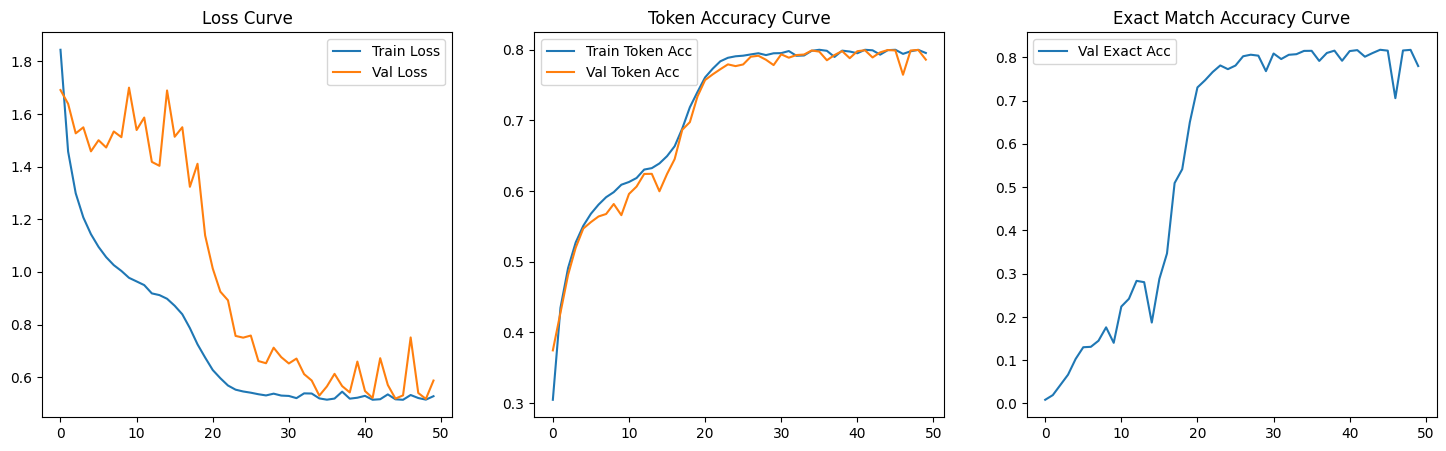

훈련 결과, 그래프, 모델 가중치, 메타정보를 'results_seq2seq_attention_add_3num' 폴더에 저장했습니다.


In [9]:
# ----------------------------------------------------------
# 학습 완료 후 결과 저장
# ----------------------------------------------------------

import os
import json
import matplotlib.pyplot as plt
import pickle

# 저장 디렉토리 생성
save_dir = "results_seq2seq_attention_add_3num"
os.makedirs(save_dir, exist_ok=True)

# 1) 학습 로그 (loss, acc 기록) 저장
history = {
    "train_losses": [float(x) for x in train_losses],
    "val_losses": [float(x) for x in val_losses],
    "train_accs": [float(x) for x in train_accs],
    "val_accs": [float(x) for x in val_accs],
    "val_exact_accs": [float(x) for x in val_exact_accs],
}
with open(os.path.join(save_dir, "history.json"), "w") as f:
    json.dump(history, f, indent=2)

# 2) 학습 곡선 그래프
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1,3,2)
plt.plot(train_accs, label="Train Token Acc")
plt.plot(val_accs, label="Val Token Acc")
plt.legend(); plt.title("Token Accuracy Curve")

plt.subplot(1,3,3)
plt.plot(val_exact_accs, label="Val Exact Acc")
plt.legend(); plt.title("Exact Match Accuracy Curve")

plt.savefig(os.path.join(save_dir, "training_curves.png"), dpi=200, bbox_inches="tight")
plt.show()
plt.close()

# 3) 모델 가중치 저장
torch.save(model.state_dict(), os.path.join(save_dir, "results_seq2seq_attention_add_3num.pt"))

# 4) 메타 정보 저장 (옵션)
meta = {
    "input_dim": INPUT_DIM,
    "output_dim": OUTPUT_DIM,
    "emb_dim": EMB_DIM,
    "hidden_dim": HIDDEN_DIM,
    "n_epochs": N_EPOCHS,
    "best_val_exact": max(val_exact_accs) if val_exact_accs else None
}
with open(os.path.join(save_dir, "meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

#5) stoi / itos 저장
with open(os.path.join(save_dir, "stoi.pkl"), "wb") as f:
    pickle.dump(train_dataset.stoi, f)

with open(os.path.join(save_dir, "itos.pkl"), "wb") as f:
    pickle.dump(train_dataset.itos, f)

print(f"훈련 결과, 그래프, 모델 가중치, 메타정보를 '{save_dir}' 폴더에 저장했습니다.")


In [10]:
# ==============================
# 9.3.4 모델 예측과 샘플 확인 (3자리 덧셈 Seq2Seq with Attention)
# ==============================

import random

# ==============================
# 예시 출력
# ==============================
@torch.no_grad()
def show_examples_seq2seq(model, test_data, n=5):
    indices = random.sample(range(len(test_data)), n)
    print("\n=== 3자리 덧셈 예시 (Seq2Seq with Attention) ===")
    for idx in indices:
        _, _, src_str, tgt_str = test_data[idx]
        pred_raw = evaluate_seq2seq(
            model, src_str,
            stoi=train_dataset.stoi,
            itos=train_dataset.itos,
            device=device,
            max_len=len(tgt_str)   # 정답 길이만큼 디코딩
        )

        # 정답/예측 → 정수 변환 후 오차 계산
        try:
            true_val = int(tgt_str.strip())
            pred_val = int(pred_raw.strip()) if pred_raw.strip().isdigit() else -1
            error = abs(true_val - pred_val) if pred_val >= 0 else "N/A"
        except:
            error = "N/A"

        print(f"문제: {src_str:<8} | 정답: {tgt_str:<6} | 예측: {pred_raw:<6} | 오차: {error}")

# -----------------------------
# 실행: 테스트 데이터 무작위 5개 확인
# -----------------------------
show_examples_seq2seq(model, test_dataset, n=5)


# -----------------------------
# 임의 입력 확인
# -----------------------------
custom_examples = [
    "123+678",
    "543+111",
    "100+390",
    "246+135",
    "88+1   "   # 실제 공백이 포함된 케이스
]

print("\n=== 임의 입력 예시 (Seq2Seq with Attention) ===")
for x in custom_examples:
    pred_raw = evaluate_seq2seq(
        model, x,
        stoi=train_dataset.stoi,
        itos=train_dataset.itos,
        device=device,
        max_len=len(x)   # 입력 길이 기준으로 충분히 설정
    )

    # 정답 계산
    try:
        a, b = x.replace(" ", "").split("+")
        true = str(int(a) + int(b))
    except:
        true = "N/A"

    try:
        true_val = int(true)
        pred_val = int(pred_raw.strip()) if pred_raw.strip().isdigit() else -1
        error = abs(true_val - pred_val) if pred_val >= 0 else "N/A"
    except:
        error = "N/A"

    print(f"문제: {x:<8} | 정답: {true:<6} | 예측: {pred_raw:<6} | 오차: {error}")



=== 3자리 덧셈 예시 (Seq2Seq with Attention) ===
문제: 491+175  | 정답: 666    | 예측: 666    | 오차: 0
문제: 62+761   | 정답: 823    | 예측: 823    | 오차: 0
문제: 98+394   | 정답: 492    | 예측: 492    | 오차: 0
문제: 515+805  | 정답: 1320   | 예측: 132    | 오차: 1188
문제: 643+8    | 정답: 651    | 예측: 651    | 오차: 0

=== 임의 입력 예시 (Seq2Seq with Attention) ===
문제: 123+678  | 정답: 801    | 예측: 801    | 오차: 0
문제: 543+111  | 정답: 654    | 예측: 654    | 오차: 0
문제: 100+390  | 정답: 490    | 예측: 500    | 오차: 10
문제: 246+135  | 정답: 381    | 예측: 381    | 오차: 0
문제: 88+1     | 정답: 89     | 예측: 89     | 오차: 0


In [11]:
import os
import torch
import pickle

# ===========================================
# 0. 저장된 폴더 지정
# ===========================================
save_dir = "results_seq2seq_attention_add_3num"  # 학습 시 사용한 동일 폴더

# ===========================================
# 1. stoi / itos 불러오기
# ===========================================
with open(os.path.join(save_dir, "stoi.pkl"), "rb") as f:
    stoi = pickle.load(f)
with open(os.path.join(save_dir, "itos.pkl"), "rb") as f:
    itos = pickle.load(f)

# ===========================================
# 2. 모델 불러오기
# ===========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_DIM = len(stoi)
OUTPUT_DIM = len(itos)      # 입력/출력 vocab 크기 (동일)
EMB_DIM = 32
HIDDEN_DIM = 192
NUM_LAYERS = 1

enc = Encoder(INPUT_DIM, EMB_DIM, HIDDEN_DIM, num_layers=NUM_LAYERS).to(device)
dec = LuongDecoder(OUTPUT_DIM, EMB_DIM, HIDDEN_DIM, num_layers=NUM_LAYERS).to(device)
loaded_model = Seq2SeqAttn(enc, dec, device).to(device)

# 가중치 불러오기 (학습 시 저장한 pt 파일)
state_dict = torch.load(
    os.path.join(save_dir, "results_seq2seq_attention_add_3num.pt"),
    map_location=device,
    weights_only=True
)
loaded_model.load_state_dict(state_dict)
loaded_model.eval()

# ===========================================
# 3. 예측 함수 (Attention 버전)
# ===========================================
@torch.no_grad()
def evaluate_seq2seq_attn(model, src_str, stoi, itos, device, max_len=5):
    # 입력 문자열을 인덱스로 변환
    src = torch.tensor([stoi[c] for c in src_str], device=device).unsqueeze(0)  # [1, 7]

    # 인코더 실행
    encoder_outputs, hidden, cell = model.encoder(src)

    # 시작 토큰 "_"로 초기화
    outputs = ["_"]
    input_tok = torch.tensor([stoi["_"]], device=device)

    # 출력 생성 (뒤 4자리)
    for _ in range(max_len - 1):
        logits, hidden, cell, attn_weights = model.decoder(
            input_tok, hidden, cell, encoder_outputs
        )
        top1 = logits.argmax(1)                 # [1]
        outputs.append(itos[top1.item()])       # 토큰 인덱스 → 문자
        input_tok = top1                        # 다음 입력은 예측 토큰

    return "".join(outputs)  # 전체 길이 5 문자열 반환

test_input = "123+999"
prediction = evaluate_seq2seq_attn(loaded_model, test_input, stoi, itos, device)

print(f"문제: {test_input}")
print(f"예측: '{prediction}'")


문제: 123+999
예측: '_1122'


문제: 123+111
예측(5자리): '_234 '


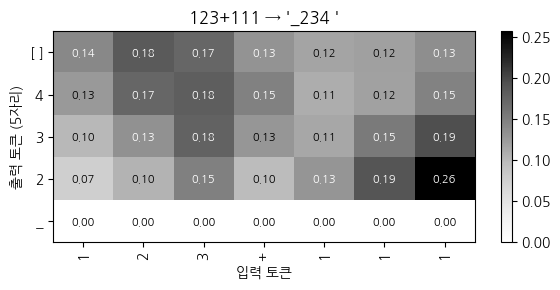

문제: 789+456
예측(5자리): '_1245'


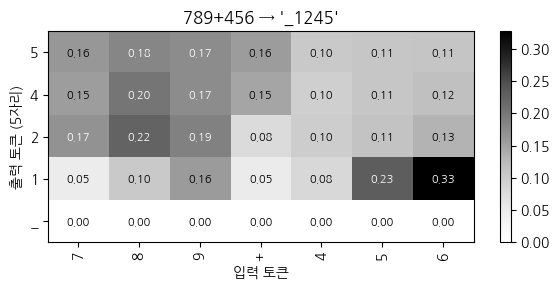

문제: 488+527
예측(5자리): '_1015'


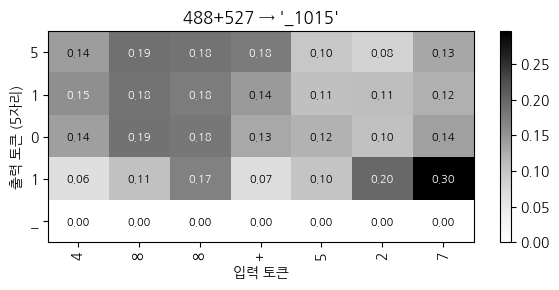

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import koreanize_matplotlib

# ----------------------------------------------------------
# 0) 보이는 라벨로 치환: ' ' -> '␣', '_' -> 'SOS'
# ----------------------------------------------------------
def _visible_tokens(tokens):
    out = []
    for t in tokens:
        if t == " ":
            out.append("[ ]")
        elif t == "_":
            out.append("_")
        else:
            out.append(t)
    return out

# ----------------------------------------------------------
# 1) Greedy decoding (어텐션 가중치 포함, 출력 5자리)
#    반환: output_tokens_5 = ["_", t1, t2, t3, t4]
#          attn_matrix_5  = [5, S] (0행은 SOS용 0행)
# ----------------------------------------------------------
@torch.no_grad()
def greedy_decode_attn_with_weights(model, src, stoi, itos, device, max_len=4):
    model.eval()
    encoder_outputs, hidden, cell = model.encoder(src)

    input_token = torch.tensor([stoi["_"]], device=src.device)  # 시작 "_"
    pred_tokens, attn_rows = [], []

    for _ in range(max_len):  # 4 step
        pred, hidden, cell, attn_weights = model.decoder(
            input_token, hidden, cell, encoder_outputs
        )
        top1 = pred.argmax(1)
        pred_tokens.append(itos[top1.item()])
        attn_rows.append(attn_weights.squeeze(0).detach().cpu().numpy())
        input_token = top1

    output_tokens_5 = ["_"] + pred_tokens  # 총 5글자

    attn_matrix = np.stack(attn_rows, axis=0) if attn_rows else np.zeros((0, src.size(1)))
    zeros_row = np.zeros((1, attn_matrix.shape[1]), dtype=attn_matrix.dtype)   # SOS 줄
    attn_matrix_5 = np.concatenate([zeros_row, attn_matrix], axis=0)           # [5, S]
    return output_tokens_5, attn_matrix_5

# ----------------------------------------------------------
# 2) 어텐션 시각화 (흑백, 값 표기, 조건부 글씨색, 보이는 라벨)
# ----------------------------------------------------------
def plot_attention(input_tokens, output_tokens, attn_matrix, title=None):
    # 라벨을 보이는 기호로 치환
    input_labels  = _visible_tokens(input_tokens)
    output_labels = _visible_tokens(output_tokens)

    T, S = attn_matrix.shape
    if T != len(output_labels):
        mT = min(T, len(output_labels))
        attn_matrix  = attn_matrix[:mT]
        output_labels = output_labels[:mT]
        T = mT
    if S != len(input_labels):
        mS = min(S, len(input_labels))
        attn_matrix = attn_matrix[:, :mS]
        input_labels = input_labels[:mS]
        S = mS

    plt.figure(figsize=(max(6, S * 0.6), max(3, T * 0.6)))
    im = plt.imshow(attn_matrix, aspect='auto', origin='lower', cmap="Greys")
    plt.colorbar(im)
    plt.xticks(ticks=np.arange(S), labels=input_labels, rotation=90)
    plt.yticks(ticks=np.arange(T), labels=output_labels)
    plt.xlabel("입력 토큰")
    plt.ylabel("출력 토큰 (5자리)")

    threshold = float(attn_matrix.max()) * 0.5 if attn_matrix.size else 0.5
    for i in range(T):
        for j in range(S):
            v = attn_matrix[i, j]
            color = "white" if v > threshold else "black"
            plt.text(j, i, f"{v:.2f}", ha='center', va='center', color=color, fontsize=8)

    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

# ==========================================
# 3) 여러 예시로 어텐션 시각화
# ==========================================
examples = [
    "123+111",
    "789+456",
    "488+527",
    
]

for ex in examples:
    padded = ex.ljust(7, " ")                 # 항상 길이 7 (오른쪽 공백 패딩)
    src = torch.tensor([stoi[c] for c in padded], device=device).unsqueeze(0)

    output_tokens_5, attn_matrix = greedy_decode_attn_with_weights(
        loaded_model, src, stoi, itos, device, max_len=4
    )

    print(f"문제: {ex}")
    print(f"예측(5자리): '{''.join(output_tokens_5)}'")

    plot_attention(
        list(padded),                   # 입력 라벨: 공백까지 포함
        output_tokens_5,                # 출력 5줄: '_' 포함
        attn_matrix,
        title=f"{ex} → '{''.join(output_tokens_5)}'"
    )
